In [1]:
import numpy as np
from matplotlib import pyplot as py
%matplotlib inline
from scipy import integrate

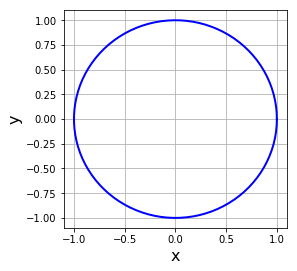

In [2]:
u_inf = 1.0
R = 1.0
x_cen, y_cen = 0.0, 0.0
theta = np.linspace(0.0, 2 * np.pi, 100)
x_cyl, y_cyl = (x_cen + R * np.cos(theta),
                y_cen + R * np.sin(theta))

size = 4
py.figure(figsize=(size,size))
py.grid()
py.xlabel('x', fontsize=16)
py.ylabel('y', fontsize=16)
py.plot(x_cyl, y_cyl, color='b', linestyle='-', linewidth=2)
py.xlim(-1.1, 1.1)
py.ylim(-1.1, 1.1);

In [3]:
class Panel:
    def __init__(self, xa, ya, xb, yb):
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2
        self.length = np.sqrt((xb - xa)**2 + (yb - ya)**2)
        
        if xb - xa <= 0.:
            self.beta = np.arccos((yb - ya) / self.length)
        elif xb - xa > 0.:
            self.beta = np.pi + np.arccos(-(yb - ya) / self.length)
        
        self.sigma = 0.0 #source strength
        self.vt = 0.0    #tangential velocity
        self.cp = 0.0    #pressure coefficient

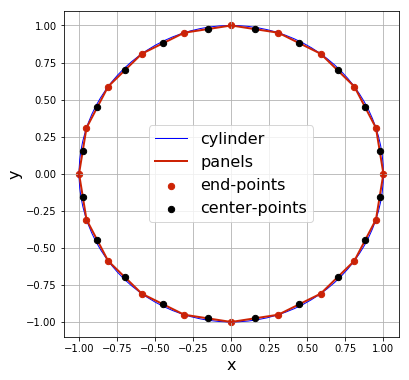

In [4]:
N_panels = 20

#endpoints
x_ends = R * np.cos(np.linspace(0.0, 2 * np.pi, N_panels + 1))
y_ends = R * np.sin(np.linspace(0.0, 2 * np.pi, N_panels + 1))

panels = np.empty(N_panels, dtype=object)
for i in range(N_panels):
    panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i + 1], y_ends[i + 1])

size = 6
py.figure(figsize=(size,size))
py.grid()
py.xlabel('x', fontsize=16)
py.ylabel('y', fontsize=16)
py.plot(x_cyl, y_cyl, label='cylinder', color='b', 
        linestyle='-', linewidth=1)
py.plot(x_ends, y_ends, label='panels', color='#CD2305',
        linestyle='-', linewidth=2)
py.scatter([p.xa for p in panels], [p.ya for p in panels],
               label='end-points', color='#CD2305', s=40)
py.scatter([p.xc for p in panels], [p.yc for p in panels],
               label='center-points', color='k', s=40, zorder=3)
py.legend(loc='best', prop={'size':16})
py.xlim(-1.1, 1.1)
py.ylim(-1.1, 1.1);

In [5]:
def integral_normal(p_i, p_j):
    def integrand(s):
        return (((p_i.xc - (p_j.xa - np.sin(p_j.beta) * s)) * np.cos(p_i.beta) +
                (p_i.yc - (p_j.ya + np.cos(p_j.beta) * s)) * np.sin(p_i.beta)) /
                ((p_i.xc -(p_j.xa - np.sin(p_j.beta) * s))**2 + 
                 (p_i.yc -(p_j.ya + np.cos(p_j.beta) * s))**2))
    return integrate.quad(integrand, 0.0, p_j.length)[0]

In [6]:
A = np.empty((N_panels, N_panels), dtype=float)
np.fill_diagonal(A, 0.5)

for i, p_i in enumerate(panels):
    for j, p_j in enumerate(panels):
        if i != j:
            A[i, j] = 0.5 / np.pi * integral_normal(p_i, p_j)
            
b = -u_inf * np.cos([p.beta for p in panels])

In [7]:
sigma = np.linalg.solve(A, b)

for i, panel in enumerate(panels):
    panel.sigma = sigma[i]

In [8]:
def integral_tangential(p_i, p_j):
    def integrand(s):
        return ((-(p_i.xc - (p_j.xa - np.sin(p_j.beta) * s)) * np.sin(p_i.beta) +
                 (p_i.yc - (p_j.ya + np.cos(p_j.beta) * s)) * np.cos(p_i.beta)) /
                ((p_i.xc - (p_j.xa - np.sin(p_j.beta) * s))**2 +
                 (p_i.yc - (p_j.ya + np.cos(p_j.beta) * s))**2))
    return integrate.quad(integrand, 0.0, p_j.length)[0]

In [9]:
A = np.empty((N_panels, N_panels), dtype=float)
np.fill_diagonal(A, 0.0)

for i, p_i in enumerate(panels):
    for j, p_j in enumerate(panels):
        if i!=j:
            A[i,j] = 0.5 / np.pi * integral_tangential(p_i, p_j)
            
b = - u_inf * np.sin([panel.beta for panel in panels])

vt = np.dot(A, sigma) + b

for i, panel in enumerate(panels):
    panel.vt = vt[i]

In [10]:
for panel in panels:
    panel.cp = 1.0 - (panel.vt / u_inf)**2

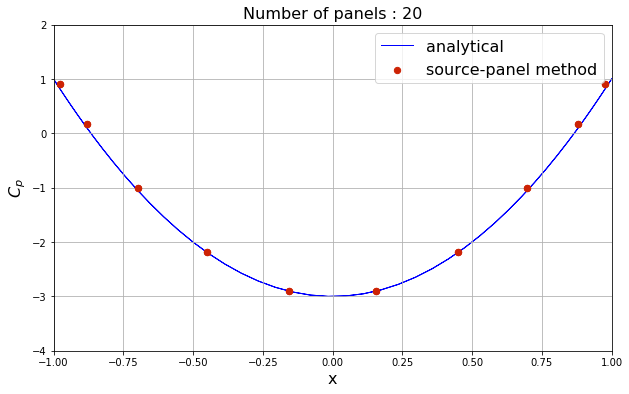

In [11]:
cp_analytical = 1.0 - 4 * (y_cyl / R)**2

py.figure(figsize=(10,6))
py.grid()
py.xlabel('x', fontsize=16)
py.ylabel('$C_p$', fontsize=16)
py.plot(x_cyl, cp_analytical, label = 'analytical', color='b',
        linestyle='-', linewidth=1, zorder=1)
py.scatter([p.xc for p in panels], [p.cp for p in panels],
           label='source-panel method', color='#CD2305', s=40, zorder=2)
py.title('Number of panels : %d' % N_panels, fontsize=16)
py.legend(loc='best', prop={'size':16})
py.xlim(-1.0, 1.0)
py.ylim(-4.0, 2.0);

In [12]:
def integral_u(p_j, x, y):
    def integrand(s):
        return ((x - (p_j.xa - np.sin(p_j.beta) * s)) /
                ((x - (p_j.xa - np.sin(p_j.beta) * s))**2 +
                 (y - (p_j.ya + np.cos(p_j.beta) * s))**2))
    return integrate.quad(integrand, 0.0, p_j.length)[0]

def integral_v(p_j, x, y):
    def integrand(s):
        return ((y - (p_j.ya + np.cos(p_j.beta) * s)) /
                ((x - (p_j.xa - np.sin(p_j.beta) * s))**2 +
                 (y - (p_j.ya + np.cos(p_j.beta) * s))**2))
    return integrate.quad(integrand, 0.0, p_j.length)[0]

In [13]:
x_start, x_end = -2.0, 2.0
y_start, y_end = -2.0, 2.0
x = np.linspace(x_start, x_end)
y = np.linspace(y_start, y_end)
X, Y = np.meshgrid(x, y)

In [14]:
u = np.zeros((50,50)) + u_inf
for j, panel in enumerate(panels):
    for i in range(50):
        for k in range(50):
            u[k,i] += (sigma[j] / (2.0 * np.pi)) * integral_u(panel, x[i], y[k])
v = np.zeros((50,50))
for j, panel in enumerate(panels):
    for i in range(50):
        for k in range(50):
            v[k,i] += (sigma[j] / (2.0 * np.pi)) * integral_v(panel, x[i], y[k])
#u_vectorized = np.vectorize(integral_u)
#v_vectorized = np.vectorize(integral_v)
#for j, panel in enumerate(panels):
#    u += (sigma[j] / (2.0 * np.pi)) * u_vectorized(panel,X,Y)
#    v += (sigma[j] / (2.0 * np.pi)) * v_vectorized(panel,X,Y)

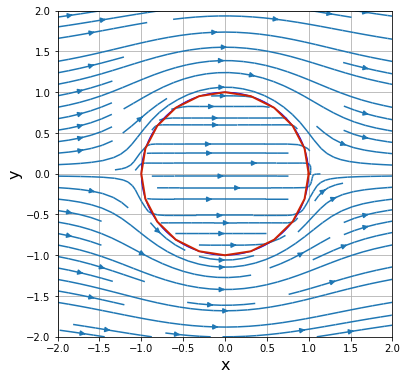

In [15]:
size = 6
py.figure(figsize=(size,size))
py.grid()
py.xlabel('x', fontsize=16)
py.ylabel('y', fontsize=16)
py.plot(x_cyl, y_cyl, label='cylinder', color='b', 
        linestyle='-', linewidth=1)
py.plot(x_ends, y_ends, label='panels', color='#CD2305',
        linestyle='-', linewidth=2)
py.xlim(-2.0, 2.0)
py.ylim(-2.0, 2.0)
py.streamplot(X,Y,u,v, density=1);

In [16]:
u_inf

1.0